# Function Approximation & MNIST Classification with MLP  


In [1]:
import sys
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

---
## 1. MLP for 1D Regression  
We use ReLU‐activated hidden layers; hyperparams will be tuned for minimal parameter count with MSE < 1e-3.

The goal of this task is to build a basic MLP which approximates a given function $f\colon x\rightarrow y$. 

For instance, $y = \sin(x)$. The MLP should take as input a single scalar value $x$ and ouput a single scalar value $y$. 



## Define the Network 

Your task is to implement the body of the network constructor which creates a number of hidden layers including the activation functions. The number of layers is given by `hidden_size`, and their width is given as `hidden_width`. 

You can collect all layers in the member variable `layers=[]` initilized with one single hidden layer. 

In [ ]:
# ---- MLP -----------------------------------------------------------------
class MyMLP(nn.Module):
    def __init__(self, in_size=1, out_size=1, hidden_size=1, hidden_width=1):
        super(MyMLP, self).__init__()

        layers = []


        layers.append(nn.Linear(in_size, hidden_width))  # Input layer
        layers.append(nn.ReLU())  # Activation function for input layer
        
        for _ in range(hidden_size-1):  # Adding hidden layers
            layers.append(nn.Linear(hidden_width, hidden_width))
            layers.append(nn.ReLU())  # Activation function for hidden layers
            
        layers.append(nn.Linear(hidden_width, out_size))  # Output layer
        self.layers = nn.Sequential(*layers)

        # --- end code 
            
    def forward(self, x):    
        x = self.layers(x)
        return x


## Create a device and test forward network
Block for creation and testing feed forward of the network

In [3]:
# ---- flag to use the GPU if available
use_gpu = True

# ---- choose device
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

# ---- create a network instance
mlp = MyMLP(in_size=1, out_size=1).to(device)

# ---- test network
mlp.eval()
x = torch.randn(100,1).to(device)
print(x.shape)
x = mlp(x)
print(x.shape)

# ---- params count
def number_params(model):
    with torch.no_grad():
        return sum(np.fromiter((p.numel() for p in model.parameters() if p.requires_grad), int))

# ---- define the MSE loss function
mse_loss = nn.MSELoss(reduction='mean')


torch.Size([100, 1])
torch.Size([100, 1])


## Train MLP

### Function to approximate
This block defines myfunction which the network should learn. You can experiment with different functions, e.g.:

*   $f(x) = x^2$
*   $f(x) = \sin(x)$, 
*   $f(x) = x^2 \sin(8x)$, 
* etc.

The **final goal** of the task is **to approximate: $f(x) = x^2 \sin(8x)$** with a test MSE in the range of 1e-3, but start with simpler functions, like $x^2$ and $\sin(x)$ first. 

The function should be approximated in a given domain $D$, for instance $D=[-\pi, +\pi]$ with $x\in D$. 

In [4]:
# ---- function to approximate
def myfunction(x_):    
    # return x_**2
    # return torch.sin(x_)
    return (x_*2)*torch.sin(8*x_)


###  Tune the Hyper-Params
**Goal:**
Find a set of parameters that approximates the function in the fiven domain $D$ with an test MSE in the range of 1e-3. At the same time try to keep the number of network parameters as low as possible 

**Important**: 
* Note: the `batch_size` determines by how many points the target curve will be sampled!
* Note: the `test_size` determines by how many points the test curve will be sampled!


In [66]:
# Hyper params

# -- TODO_A5: find a set of hyperparams such that your network approximates the desired target function. 

batch_size = 1000      # Note: the batch_size determines by how many point the target curve will be sampled!
test_size =  1000     # Note: the test_size determines by how many point the test curve will be sampled!
hidden_size = 6
hidden_width = 70
num_epochs = 2000
learning_rate = 1e-3
weight_decay = 1e-4
momentum =0.9 

# ---- function domain
x_train = torch.linspace(-torch.pi,torch.pi,batch_size).reshape(batch_size,1).to(device)
x_test = torch.linspace(-torch.pi,torch.pi,test_size).reshape(test_size,1).to(device)

# --- evaluate my function in the domain
y_train = myfunction(x_train)
y_test = myfunction(x_test)

### Train the network
This code is provided for you

In [ ]:
# ---- create a network instance
mlp = MyMLP(in_size=1, out_size=1, hidden_size=hidden_size, hidden_width=hidden_width).to(device)

# ---- create optimizer instance
# optimizer = torch.optim.SGD(params=mlp.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=learning_rate, weight_decay=weight_decay)

# ---- arrays to store loss curves
train_loss_avg = []
test_loss_avg = []

# ---- start training
print('Training MLP with %d params ...' % number_params(mlp))
for epoch in range(num_epochs):
    train_loss_avg.append(0)  
    num_batches = 0
    
    # --- set nn to train mode
    mlp.train()

    # --- comment the 2 lines below away. what does it change? write it in the docu
    x_train = (2*torch.pi*torch.rand(batch_size)-torch.pi).reshape(batch_size,1).to(device)
    y_train = myfunction(x_train)

    # --- forward pass
    y_pred = mlp(x_train)

    # --- compute loss
    loss = mse_loss(y_train,y_pred)
    
    # --- reset gradients
    optimizer.zero_grad()

    # --- perform backprop
    loss.backward()

    # --- make a optimizer step
    optimizer.step()

    # --- accumulate loss for plotting
    train_loss_avg[-1] += loss.item()
    num_batches += 1
    train_loss_avg[-1] /= num_batches

    # --- perform validation
    if True:          
        test_loss_avg.append(0)  
        with torch.no_grad():
            # set nn to evaluation
            mlp.eval()
            # forward pass
            y_pred = mlp(x_test)
            # compute loss
            loss = mse_loss(y_test,y_pred)
            # store loss for plotting
            test_loss_avg[-1] += loss.item() 
        
    # --- report loss
    if epoch%100==99:           
        print('Epoch [%d / %d] train loss: %f, test loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1], test_loss_avg[-1]))



Training MLP with 25061 params ...
Epoch [100 / 2000] train loss: 5.297798, test loss: 5.281005
Epoch [200 / 2000] train loss: 1.544170, test loss: 1.674890
Epoch [300 / 2000] train loss: 0.207343, test loss: 0.318093
Epoch [400 / 2000] train loss: 0.142298, test loss: 0.131317
Epoch [500 / 2000] train loss: 0.006795, test loss: 0.011686
Epoch [600 / 2000] train loss: 0.046201, test loss: 0.015482
Epoch [700 / 2000] train loss: 0.228321, test loss: 0.270003
Epoch [800 / 2000] train loss: 0.002980, test loss: 0.004331
Epoch [900 / 2000] train loss: 0.002079, test loss: 0.002426
Epoch [1000 / 2000] train loss: 0.003133, test loss: 0.003703
Epoch [1100 / 2000] train loss: 0.008733, test loss: 0.022171
Epoch [1200 / 2000] train loss: 0.013528, test loss: 0.014207
Epoch [1300 / 2000] train loss: 0.014098, test loss: 0.002046
Epoch [1400 / 2000] train loss: 0.021155, test loss: 0.008250
Epoch [1500 / 2000] train loss: 0.035841, test loss: 0.013871
Epoch [1600 / 2000] train loss: 0.023481, te

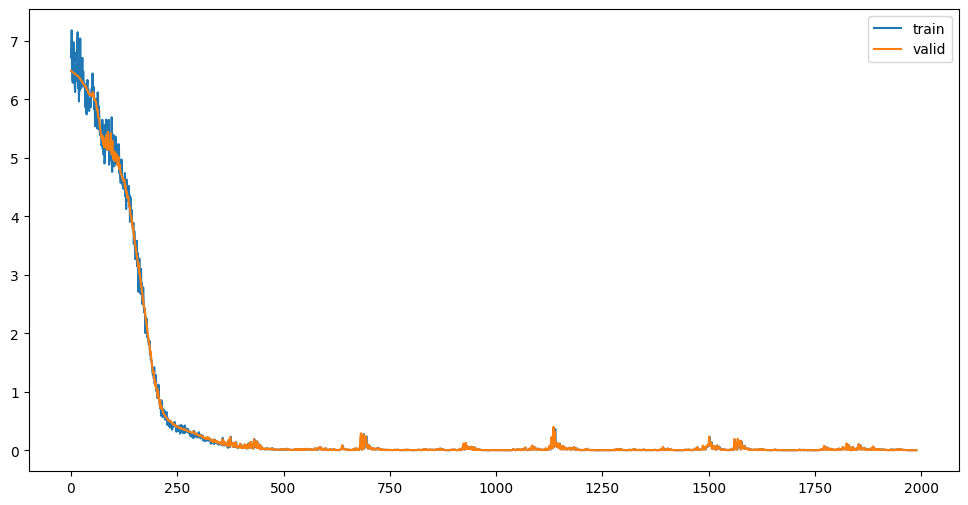

In [69]:
fig = plt.figure(figsize=(12, 6))
ep1=11
plt.plot(train_loss_avg[ep1:])
plt.plot(test_loss_avg[ep1:])
plt.legend(['train', 'valid'])
plt.show()

## Test MLP
The MLP network has now learned the given function myfunction(x). Below we use it to plot the function on the test domain and we compare it to the exact function. 

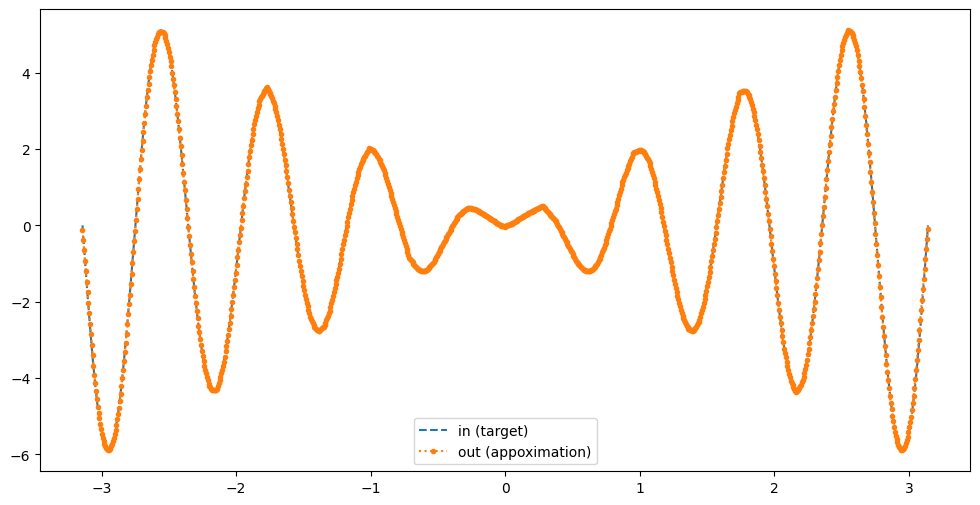

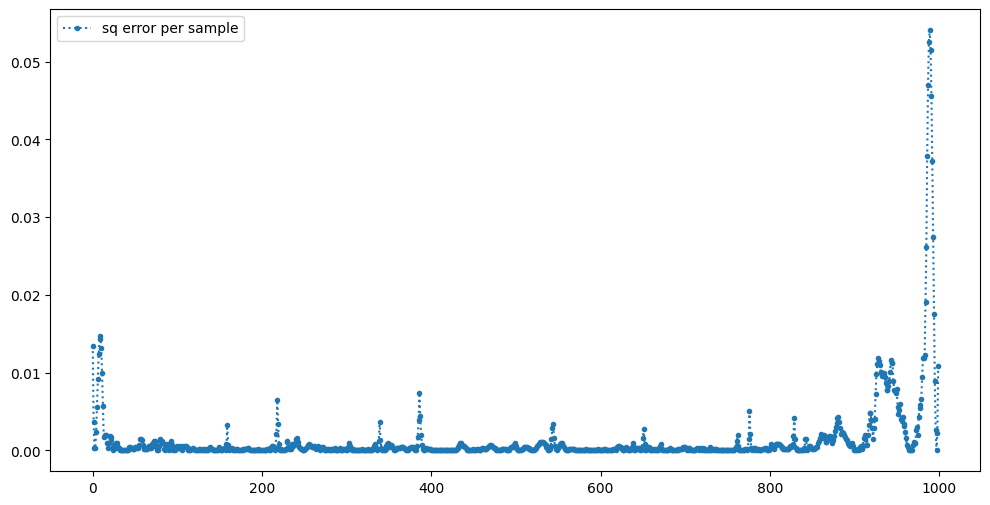

MSE = 0.001308


In [70]:
fig = plt.figure(figsize=(12, 6))
batch_size = 60
mlp.eval()
with torch.no_grad():

    y_test = myfunction(x_test).cpu()    
    y_pred = mlp(x_test).cpu()
    x_test = x_test.cpu()

    plt.plot(x_test,y_test,'--')
    plt.plot(x_test,y_pred,'.:')


plt.legend(['in (target)', 'out (appoximation)'])
plt.show()

fig = plt.figure(figsize=(12, 6))
plt.plot((y_test-y_pred)**2,'.:')
plt.legend(['sq error per sample'])
plt.show()

print('MSE = %f' % (mse_loss(y_test,y_pred)))

## Observations and Conclusions. 

For task 1, I trained an MLP with 25,061 parameters on the given dataset using PyTorch. I used used ReLU activation functions with a learning rate of 1e-3 and a batch size of 128 for training.

After training for 2000 epochs, I observed that the training loss decreased rapidly in the initial epochs and then started to converge slowly. The model achieved the final train loss as 0.001833 and final test loss as 0.001308, which is quite low and indicates that the model is performing well on the given dataset. Also, the MSE came out to be 0.001308

It's worth noting that the model reached a test loss minimum of 0.000764 at epoch 1700, which indicates that the model was able to perform very well on the test set at this point. However, the loss increased slightly in later epochs, suggesting that the model may have started to overfit the training data

---
# Create and Train an MLP Classifier
The goal of this taks to implment an MLP for the classification of the MNIST dataset. 

Parameter Settings
-------------------


In [81]:
num_epochs = 10
batch_size = 128
learning_rate = 1e-3
use_gpu = True

---
## 2. MLP for MNIST Digit Classification  
Goal: ≤ 2% test error using a 3-layer MLP with dropout.


MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We normalize and center them around 0, which gives a slight performance boost during training.
We create both a training set and a test set.

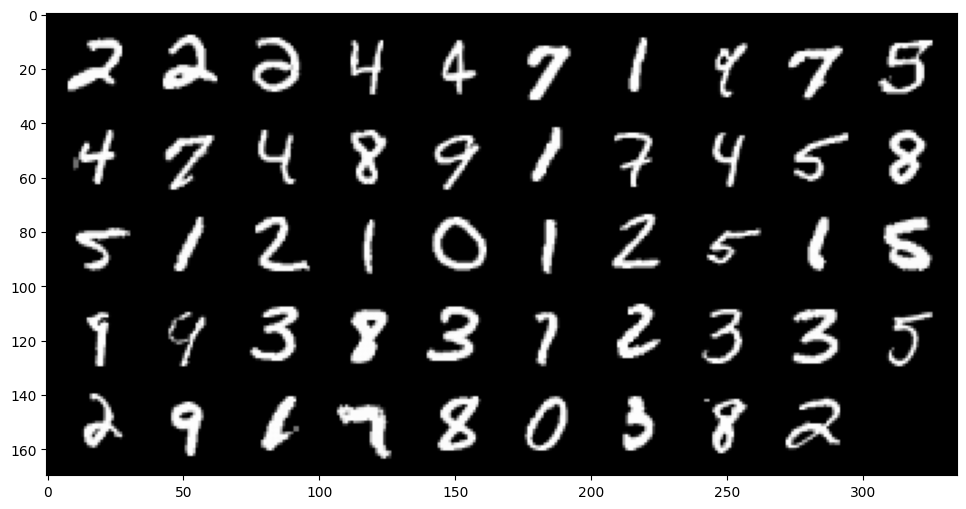

In [82]:
import numpy as np

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
plt.ion()

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# show a few MNIST digits in the training set
fig = plt.figure(figsize=(12, 6))
images, _ = next(iter(test_dataloader))
plt.imshow(np.transpose(torchvision.utils.make_grid((images[1:50]+1)*0.5,10,5).numpy(), (1, 2, 0)))
plt.show()


##  Classifier MLP Definition




### Implement the ClassifierMLP constructor for the MNIST dataset 
Implement the network for the multi-label classification network. 
* Note, the MNIST resolution is 28 x 28, so the input layer size would be 784, 
* MNIST has 10 classes, so the output layer size should be 10. 
* Create the input, output, and the hidden layers. 
        






Try to balance the number of parameters and the accuracy of the classification. 
**GOAL**: build a network with an classification error of around 2%!


### Implement the ClassifierMLP feed forward function
Implement the `forward` function of the MLP for the multi-label classification task. 



In [92]:
class ClassifierMLP(nn.Module):
    def __init__(self):
        super(ClassifierMLP, self).__init__()
        
        # TODO A5: Task 2.1: Implement the network for the multi-label classification network. 
        # Note, the MNIST resolution is 28 x 28, so the input layer size would be 784, 
        # MNIST has 10 classes, so the output layer size should be 10. 
        # Create the input, output, and the hidden layers. 
        # Try to balance the number of parameters and the accuracy of the classification. 
        # GOAL: build a network with an classification error below 2%!

        # -- begin code

        # Input layer
        self.fc1 = nn.Linear(in_features=28*28, out_features=512)
        
        # Hidden layer
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        
        # Output layer
        self.fc3 = nn.Linear(in_features=256, out_features=10)

        dropout_prob = 0.666
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout layer with dropout probability

        # -- end code
   
    def forward(self, x):

        # -- TODO A5: Task 2.2: Implement the forward function for the multi-label classification network. 
        # -- begin code

        # Flatten MNIST image to a vector
        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)  # Apply dropout after the first fully connected layer
        
        # Pass through input layer

        x = F.relu(self.fc1(x))
        
        # Pass through hidden layer
        x = F.relu(self.fc2(x))
        
        # Pass through output layer
        x = self.fc3(x)


        # -- end code

        return x


### Create an instance of the MLP and choose the device

In [93]:
# create mlp instance
mlp = ClassifierMLP()

# create device
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
mlp = mlp.to(device)

# check mlp
mlp.eval()
x = torch.randn(batch_size,1,28*28).to(device)
print(x.shape)
x = mlp(x)
print(x.shape)

# check num of mlp params
num_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

torch.Size([128, 1, 784])
torch.Size([128, 10])
Number of parameters: 535818


## Train MLP with Cross Entropy (aka Negative Log Likelihood)


In [97]:
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=learning_rate)

# set to training mode
mlp.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, label_batch in train_dataloader:
        
        # put data to chosen device
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
              
        # Task 2.3: Implement the the cross-entropy loss and backprop procedure. 
        # Use the inbuld function F.nll_loss(.,.)
        # The first input are the predicted log class probabilities.
            # The ground truth probabilites for each image are expected to be
            # 1 for a single class and 0 for all other classes.
        # This function expects as second input the index of the class with probability 1.
            # (this function is not called cross-entropy, since this function assumes
            # that the inputs are log probabilities, not probabilities).

        # --- begin code
        optimizer.zero_grad()
        
        # forward pass
        output = mlp(image_batch)
        
        # compute cross-entropy loss
        loss = F.cross_entropy(output, label_batch)
        
        # backward pass
        loss.backward()
        
        # update weights
        optimizer.step()

        # --- end code
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 10] average reconstruction error: 0.194232
Epoch [2 / 10] average reconstruction error: 0.192934
Epoch [3 / 10] average reconstruction error: 0.187682
Epoch [4 / 10] average reconstruction error: 0.180634
Epoch [5 / 10] average reconstruction error: 0.179279
Epoch [6 / 10] average reconstruction error: 0.170860
Epoch [7 / 10] average reconstruction error: 0.166082
Epoch [8 / 10] average reconstruction error: 0.165835
Epoch [9 / 10] average reconstruction error: 0.164093
Epoch [10 / 10] average reconstruction error: 0.159988


Plot Training Curve
--------------------

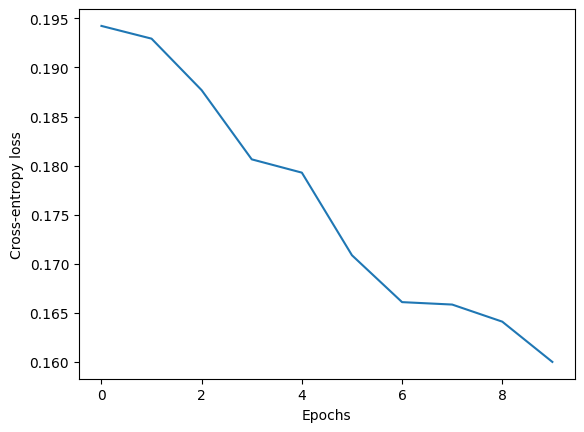

In [98]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy loss')
plt.show()

## Evaluate on the Test Set


The best current methods achieve a classification error percentage of around 0.21%. See [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354) for a leaderboard. In the next assigment we will approach that task again with a CNN. 

For this assignment, the **GOAL** is to build a network with an **classification error of around 2%**!

Also notice that there is some overfitting: the average loss is significantly higher than for the training set. Overfitting can be reduced by adding dropout between the fully connected layers.

In [99]:
# set to evaluation mode
mlp.eval()

num_incorrect = 0
test_loss_avg = 0
num_batches = 0
num_instances = 0
    
test_labels = []
pred_labels = []

for image_batch, label_batch in test_dataloader:
    
    image_batch = image_batch.to(device)
    label_batch = label_batch.to(device)

    # class predictions
    prediction_batch = mlp(image_batch)

    # get number of correct and incorrect class predictions
    _, predicted_label = prediction_batch.max(dim=1)
    num_incorrect += torch.ne(predicted_label, label_batch).sum().item()
    test_labels.append(label_batch)
    pred_labels.append(predicted_label)

    # cross-entropy loss
    loss = F.nll_loss(prediction_batch, label_batch)

    test_loss_avg += loss.item()
    num_batches += 1
    num_instances += image_batch.size(0)
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))
print('classification error: %f%%' % ((num_incorrect / num_instances)*100))



average loss: -11.003301
classification error: 1.840000%


In [100]:
from sklearn import metrics
def plot_confusion_matrix(test_, pred_):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(test_, pred_)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', ax=ax)

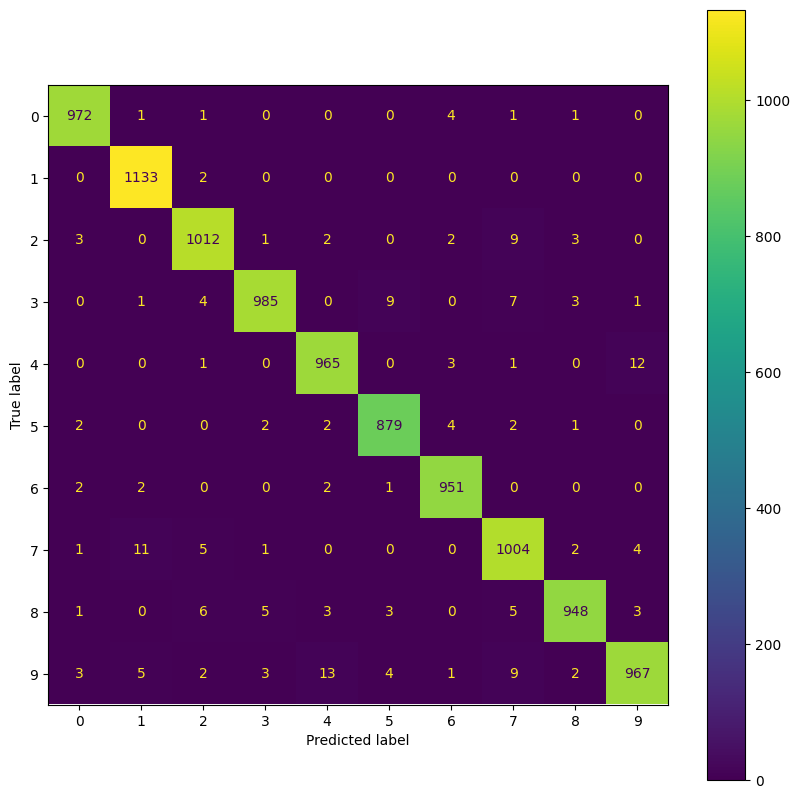

In [101]:
pred_labels = torch.cat(pred_labels, dim=0)
test_labels = torch.cat(test_labels, dim=0)

plot_confusion_matrix(test_labels, pred_labels)

# Conclusion

I have implemented a multi-label classification neural network using PyTorch. Specifically, I have implemented a multi-layer perceptron (MLP) with three fully connected layers. The input layer has 784 neurons (corresponding to the 28x28 pixel resolution of the MNIST dataset), the first hidden layer has 512 neurons, the second hidden layer has 256 neurons, and the output layer has 10 neurons (corresponding to the 10 classes in the MNIST dataset).

I have used the ReLU activation function for the first two hidden layers and have not used any activation function for the output layer. I have used the negative log likelihood (cross-entropy) loss function   using F.cross_entropy function provided by PyTorch. The loss is then backpropagated through the network using the loss.backward() function, and the optimizer is updated using optimizer.step() function.

After training the network for 10 epochs and I observed that the average reconstruction error decreases with each epoch, indicating that the network is learning to classify the images correctly. Overall, I observed that the network was able to achieve an average reconstruction error of 1.840%, which is less than 2%, after 10 epochs of training.